In [224]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
import cv2
from pathlib import Path
from tqdm import tqdm
import math
import pdfplumber
import pytesseract as pyt
import tempfile
%matplotlib inline

from ksatparser.utils import *
from ksatparser.problem_parser import extract_T

In [345]:
# path
test_name = "2022_7_media"
pdf_dir = Path("pdf/explanation/")
output_dir = Path("output/")
pdf_path = pdf_dir/(test_name+".pdf")

# 페이지를 세 구획으로 자르고 이어주기

In [353]:
imgs = pdf2pngs(pdf_path)
img = imgs[0]

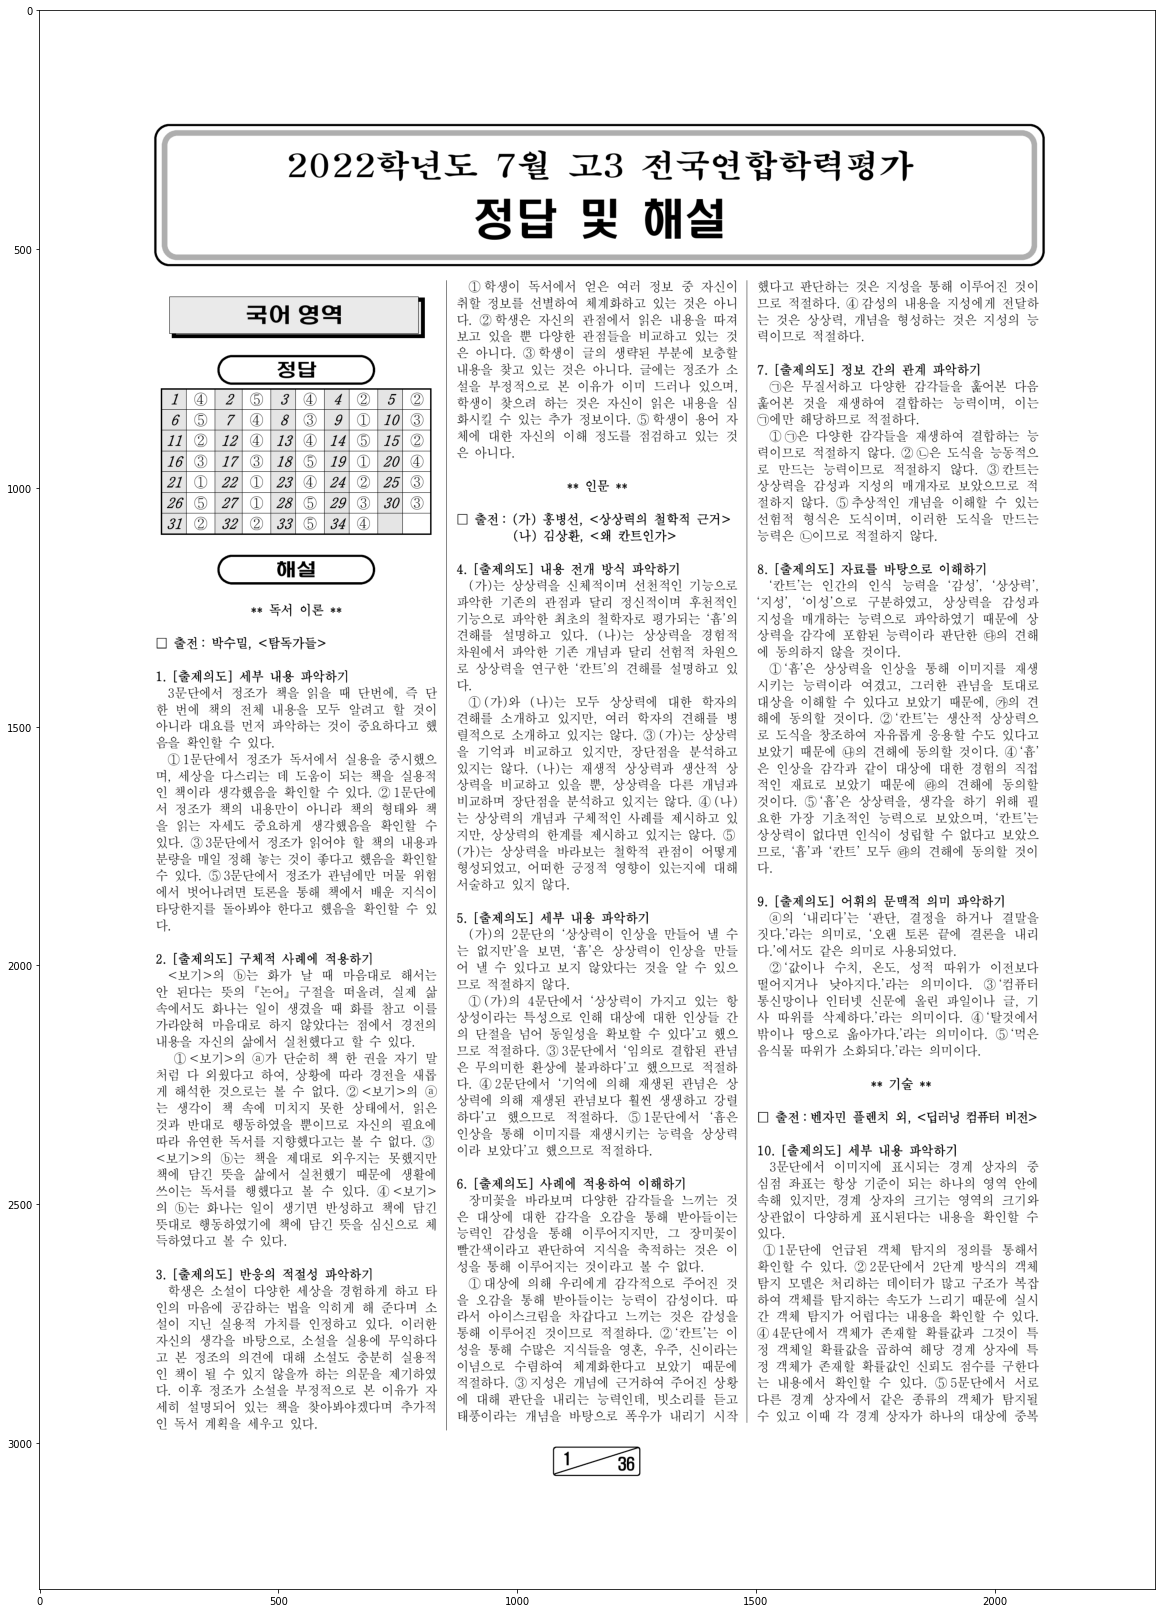

In [354]:
imshow(img)

In [355]:
# canny preprocessing
thresh1 = 400 # 낮을수록 더 많은 line들을 뽑아냄, line일 확률 떨어짐
thresh2 = 10
dst = cv2.Canny(img, thresh1, thresh2)

# problematic hough
lines = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 100, 20)

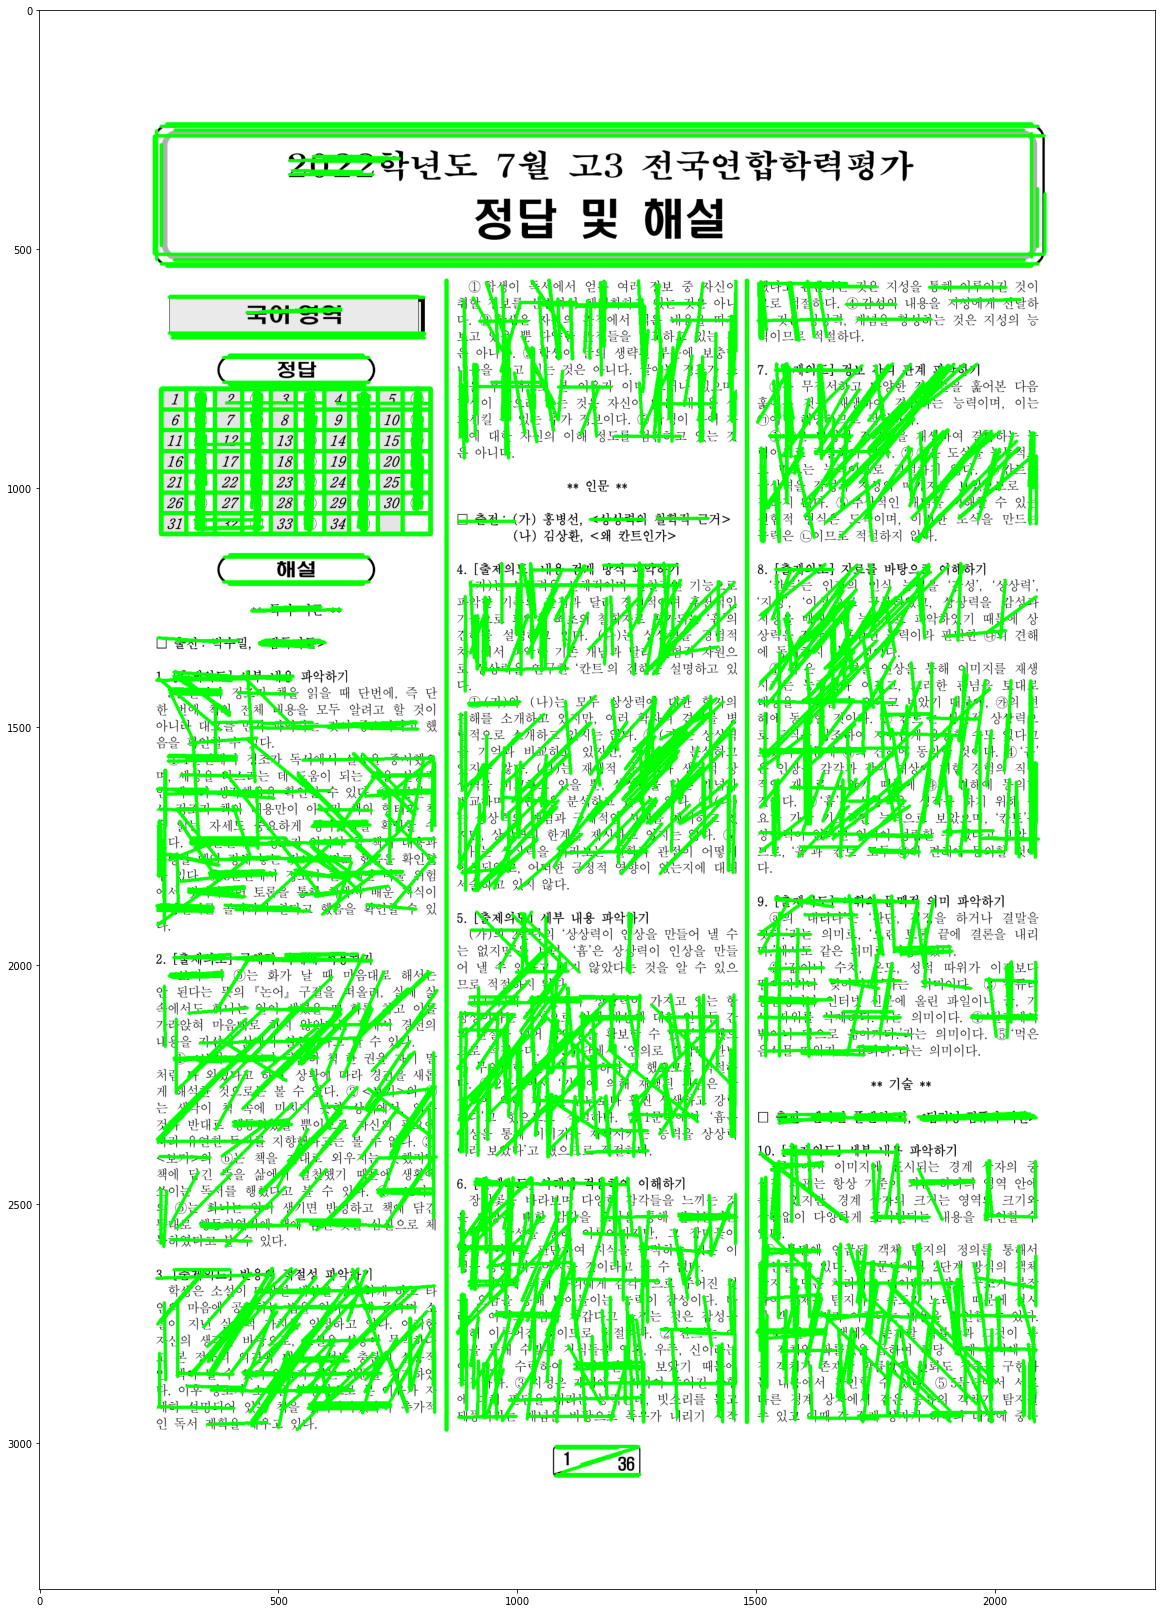

In [356]:
# how to scratch line in img
x1,y1,x2,y2 = lines[0][0]
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(cimg, (x1,y1), (x2,y2), (0,255,0), 5)
imshow(cimg)

In [357]:

def parse_explanation(pdf_path, output_dir):
    pass

def get_elements_list(pdf_path, imgs):
    blocks = []
    probs_list = []
    jimoons_list = []
    jimoon_names = []  # string
    prob_names = []  # string

    y_top_padding = 7  # fix pdfplumber position error

    with pdfplumber.open(str(pdf_path)) as pdf:
        for i, page in enumerate(pdf.pages):
            img = imgs[i]
            h, w = img.shape
            cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            words = page.extract_words()

            # jimoon
            jimoon_words = find_jimoon_words(words)
            jimoons = []
            for jw in jimoon_words:
                x0, y0, x1, y1 = get_xy(jw, page.width, page.height)
                xys = x0, y0, x1, y1 = int(x0 * w), int(y0 * h) - y_top_padding, int(x1 * w), int(y1 * h)

                # replace [p0~p1] to [p0-p1]
                jimoon_name = jw['text'][1:-1]
                jimoon_name = jimoon_name.replace('～', '-')

                jimoons.append((xys, jimoon_name))

            # problem
            prob_words = find_problem_words(words)
            probs = []
            for pw in prob_words:
                x0, y0, x1, y1 = get_xy(pw, page.width, page.height)
                xys = x0, y0, x1, y1 = int(x0 * w), int(y0 * h) - y_top_padding, int(x1 * w), int(y1 * h)

                probs.append((xys, pw['text'][:-1]))

            # divide page into block
            # ebs해설(평가원 기출)은 하나의 block, 교육청 해설은 세개의 block으로 이루어짐
            # canny preprocess
            thresh1 = 1520
            thresh2 = 1000
            dst = cv2.Canny(img, thresh1, thresh2)

            # problematic hough
            lines = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 100, 20)

            # extract T
            vertline, horline = extract_T(lines)
            x1, y1, _, y0 = vertline[0]
            if y0 > y1:
                y0, y1 = y1, y0
            x0, _, x2, _ = horline[0]

            # T가 없는 페이지는 제외
            if x2-x0 < 2*jbox_width:
                continue

            # extract jbox candidates
            jbox_candidates = []
            for l in lines:
                l = l[0]
                if abs(l[2] - l[0]) >= jbox_width:
                    overlap = False
                    for ll in jbox_candidates:
                        if abs(ll[1] - l[1]) < 6:
                            overlap = True
                    if not overlap:
                        jbox_candidates.append(l)
                        cv2.line(cimg, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 2)

            # T preprocess (dilate spaces)
            x0 -= 15
            x2 += 15
            y0 += 15
            mid_margin = 25

            # divide left&right and preprocess
            for xmin, ymin, xmax, ymax in [(x0, y0, x1 - mid_margin, y1), (x1 + mid_margin, y0, x2, y1)]:
                blocks.append(img[ymin:ymax, xmin:xmax])

                probs_list.append([])
                for prob in probs:
                    (x0, y0, x1, y1), name = prob
                    if xmin <= x0 < xmax:
                        prob = x0 - xmin, y0 - ymin, x1 - xmin, y1 - ymin
                        probs_list[-1].append(prob)
                        prob_names.append(name)

                jimoons_list.append([])
                for jimoon in jimoons:
                    (x0, y0, x1, y1), name = jimoon
                    if xmin <= x0 < xmax:
                        jimoon = x0 - xmin, y0 - ymin, x1 - xmin, y1 - ymin
                        jimoons_list[-1].append(jimoon)
                        jimoon_names.append(name)
    return blocks, jimoons_list, jimoon_names, probs_list, prob_names

def save_explanation(pdf_path, long_block, jimoons, jimoon_names, probs, prob_names, output_dir):
    pass

def extract_2_suburb_horizontals(lines, width):
    # width is img.shape[1]
    thresh = 0.4
    yloc = []
    maxy = 0
    for i, line in enumerate(lines):
        x1,y1,x2,y2 = line[0]
        thresh_w = thresh*width
        if abs(x2-x1) >= thresh_w:
            yloc.append((y1,i))
    
    yloc.sort()
    print(yloc)
    yi1 = yloc[0][1]
    yi2 = yloc[-1][1]
    return lines[yi1][0], lines[yi2][0]

def extract_2_verticals(lines):
    '''
    arguments : list([x1,y1,x2,y2])
    return : (max length left vertical line, max length right vetical line)
    '''
    ylen = []
    maxy = 0
    for i, line in enumerate(lines):
        _,y1,_,y2 = line[0]
        ylen.append(abs(y2-y1))
    
    tmp = [(y, i) for i, y in enumerate(ylen)]
    tmp.sort(reverse=True)
    yi1 = tmp[0][1]
    x1,y1,x2,y2 = lines[yi1][0]
    yi2 = 0
    for _,i in tmp[1:]:
        x,_,_,_ = lines[i][0]
        if abs(x-x1) > 20:
            yi2 = i
            break
    return lines[yi1][0], lines[yi2][0]

def is_two_vertical(line1, line2, height):
    '''
    두개의 긴선이 있는지 확인하는 함수
    ebs 해설지인지 교육청 해설지인지 구분한다
    평가원 해설지 - ebs에서 제작 : ebs이므로 두개의 선으로 나눠져있지 않음
    평가원 이외 해설지 : 두개의 선으로 나눠져있음
    '''
    x11,y11,x12,y12 = line1
    x21,y21,x22,y22 = line2
    thresh = 0.65
    # 선이 전체 height의 thresh만큼의 길이 이상인지 확인
    if not (abs(y12-y11) > height*thresh and abs(y22-y21) > height*thresh):
        return False
    return True

def get_min_max_x(img):
    _, thresh = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
    width = thresh.shape[1]
    xmin, xmax = 0, thresh.shape[1]-1
    for i in range(width):
        if not all(thresh[:, i]):
            xmin = i
            break
    for i in reversed(range(width)):
        if not all(thresh[:, i]):
            xmax = i
            break
    return xmin,xmax

In [364]:
xmin,xmax,ymin,ymax = img.shape[1], 0, img.shape[0], 0
vline1, vline2 = extract_2_verticals(lines)
width = img.shape[1]
height = img.shape[0]
x_padding = 22
if is_two_vertical(vline1, vline2, height):
    # vertical line 2개가 있는거라면
    for line in (vline1, vline2):
        x1,y1,x2,y2 = line
        if y2<y1:
            y1,y2 = y2,y1
        ymin = min(ymin, y1)
        ymax = max(ymax, y2)
else:
    # vertical line 2개가 없음 => ebs 해설지
    y_padding
    hline1, hline2 = extract_2_suburb_horizontals(lines, width)
    ymin, ymax = hline1[1]+y_padding, hline2[1]-y_padding
xmin, xmax = get_min_max_x(img[ymin:ymax])
xmin -= x_padding
xmax += x_padding

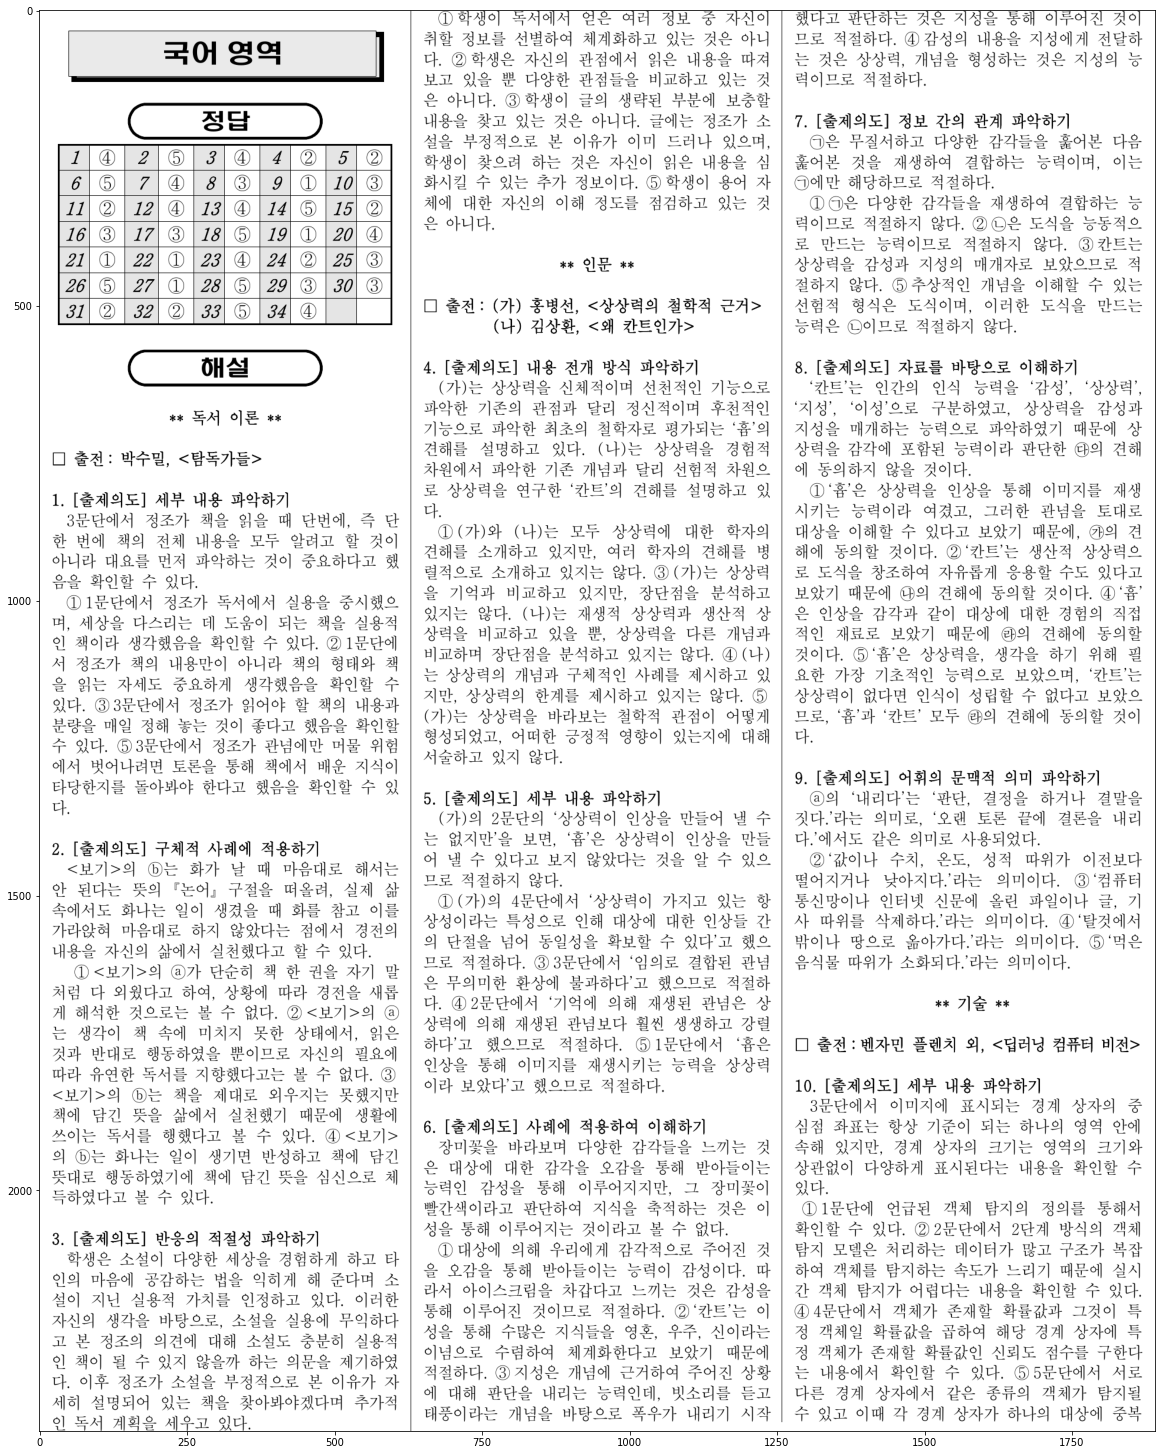

In [365]:
imshow(img[ymin:ymax, xmin:xmax])

# 문제 자르기

In [ ]:
[1~3][1~3]~

In [366]:
'～'=='~'

False

In [367]:
'~'=='~'

True